# Upper Confidence Bound

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Importing the dataset

Dataset:
- There are 10 different ads (with different designs).
- *Simulates* that each row is a user session where the user can click on the ads.
- Each row is equivalent to one round.
- ☝🏻 **Important**: in reality, this is an interactive process and the UCB determines which ads should be shown. Here, with a static dataset, we just see the final results after 10,000 rounds, so it's just an screenshot of the overall process.
- In fact, a user session might not necessarily show all ads.

In [2]:
dataset = pd.read_csv("./filez/Ads_CTR_Optimisation.csv")
dataset.head()

,Ad 1,Ad 2,Ad 3,Ad 4,Ad 5,Ad 6,Ad 7,Ad 8,Ad 9,Ad 10
0,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Ad 1    10000 non-null  int64
 1   Ad 2    10000 non-null  int64
 2   Ad 3    10000 non-null  int64
 3   Ad 4    10000 non-null  int64
 4   Ad 5    10000 non-null  int64
 5   Ad 6    10000 non-null  int64
 6   Ad 7    10000 non-null  int64
 7   Ad 8    10000 non-null  int64
 8   Ad 9    10000 non-null  int64
 9   Ad 10   10000 non-null  int64
dtypes: int64(10)
memory usage: 781.4 KB


### Implementing the UCB algo

In [4]:
def ucb(rounds: int):
    """
    - Use first 10 rounds as trial rounds due to lack of prior ad selection knowledge.
    - Set if condition (numbers_of_selections[i] > 0) to ensure each ad is selected once before main algorithm.
    - Compute average reward and upper confidence bound for each ad in the second step.
    - Apply a trick in else condition: set upper_bound to a high number to guarantee each ad is selected in trial rounds.
    - Proceed with standard algorithm steps after 10 trial rounds.
    """
    N = rounds  # num of users (rounds)
    d = 10  # num of ads
    ads_selected = []  # ads selected over the rounds (10K elements in the end)
    numbers_of_selections = [0] * d  # counts the selected ads
    sums_of_rewards = [0] * d  # sum the rewards from selected ads
    total_reward = 0

    for n in range(0, N):
        ad = 0
        max_upper_bound = 0
        for i in range(0, d):
            if numbers_of_selections[i] > 0:
                average_reward = sums_of_rewards[i] / numbers_of_selections[i]
                delta_i = math.sqrt(
                    3 / 2 * math.log(n + 1) / numbers_of_selections[i]
                )  # n+1 to avoid infinity
                upper_bound = average_reward + delta_i
            else:
                upper_bound = 1e400
            if upper_bound > max_upper_bound:
                max_upper_bound = upper_bound
                ad = i
        ads_selected.append(ad)
        numbers_of_selections[ad] += 1
        reward = dataset.values[n, ad]
        sums_of_rewards[ad] += reward
        total_reward += reward

    print(numbers_of_selections)
    return ads_selected

### Generic function to display histograms

In [5]:
def show_histogram(ads_selected):
    # Define bin edges so that each integer value (x-axis) is at the center of a bin
    bin_edges = np.arange(min(ads_selected) - 0.5, max(ads_selected) + 1.5, 1)

    # Plot histogram and get values
    counts, _, patches = plt.hist(
        ads_selected, bins=bin_edges, align="mid", rwidth=0.8, color="#9999ff"
    )

    # Find the index of the highest bin
    max_bin_index = np.argmax(counts)

    # Highlight the highest bin in a different color
    patches[max_bin_index].set_fc("#ff9999")  # Soft red color

    # Set x-axis ticks to integer values
    plt.xticks(range(min(ads_selected), max(ads_selected) + 1))

    # Add titles and labels
    plt.title("Histogram of ads selections")
    plt.xlabel("Ads")
    plt.ylabel("Number of times each ad was selected")

    # Show plot
    plt.show()

### Visualising the results for 10,000 rounds

[705, 387, 186, 345, 6323, 150, 292, 1170, 256, 186]


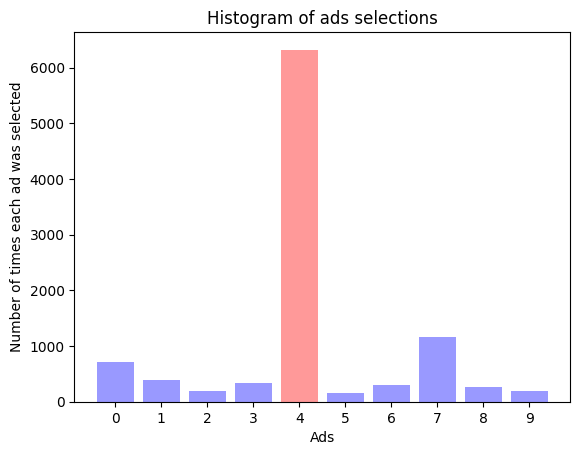

In [6]:
# Ad 4 is clear winner with 10,000 rounds
ads_selected = ucb(10000)
show_histogram(ads_selected)

### Visualising the results for 500 rounds

[60, 51, 35, 35, 79, 31, 51, 81, 42, 35]


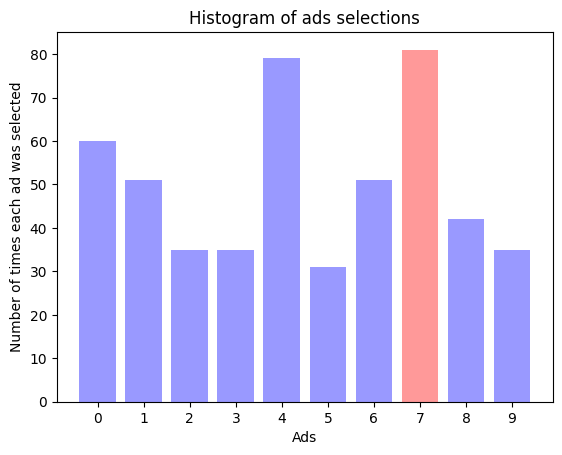

In [7]:
# Same result with 1,000 rounds, but... Ad 7 is winner with 500 rounds!!
ads_selected = ucb(500)
show_histogram(ads_selected)

    Conclusion -> results will differ depending on the number of rounds.

### Step-by-Step Example of an Advertising Campaign Using UCB

1. **Initial Setup (Rounds 1 to 5)**:
   - **Round 1**: Show ad 1 to a user. If it's clicked, count it as a reward.
   - **Round 2**: Show ad 2 to the next user, and so on.
   - In the first 5 rounds, each ad is shown once. This is important for UCB to have initial data on all ads.

2. **Start Using UCB (From Round 6 Onwards)**:
   - Now, you have some data on each ad (whether they were clicked or not in their first showing).
   - For each ad, calculate two things:
     - **Average Reward**: The number of clicks divided by the number of times shown.
     - **Confidence Interval**: A value that increases the less frequently an ad has been shown. It represents the potential of an ad that hasn't been explored enough.

3. **Selecting Ads to Display**:
   - In each subsequent round, for each ad, add the average reward and the confidence interval. This sum is the "UCB value" for each ad.
   - The ad with the highest UCB value is shown to the next user.
   - Why? The high UCB value could be due to a high average reward (a frequently clicked ad) or a high confidence interval (an ad not shown enough but with potential).

4. **Updating the Data**:
   - After showing the ad, update its data. If it was clicked, increase its click count. Always update the number of times it's been shown.
   - Recalculate the average reward and confidence interval for this ad.

5. **Repeating the Process**:
   - Continue this process for each user/session.
   - The algorithm naturally balances between showing the best-performing ads so far (exploitation) and trying out less shown ads (exploration).

### Example Scenario

- **Round 1 to 5**: Show each ad once. Let’s say ads 1, 3, and 5 get clicked, but ads 2 and 4 don’t.
- **Round 6**: Calculate UCB values for all ads. Ads 2 and 4 will have higher confidence intervals as they have been shown less. Suppose ad 2 has the highest UCB value now.
- **Show Ad 2**: If it gets clicked, its average reward increases. If not, its confidence interval reduces slightly.
- **Round 7**: Recalculate UCB values. Maybe now ad 4 has the highest UCB, or ad 1 has taken over because it's been clicked every time it's shown.

### Conclusion

The UCB method ensures that over time:
- Ads that perform well are shown more often.
- Ads that haven’t had much chance yet still get occasionally shown.
- The campaign adapts and evolves based on real user interactions, finding a balance between trying out different ads and focusing on the ones that work best.